In [329]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [330]:
nov_test=pd.read_csv("NOV_test_data.csv")
nov_test

,Unnamed: 0,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,0,2020-11-01 10:00:00,77.6,10.1,327.0,1.0,NaN,27.6,31.90,7.95,8.26,7.69,5.13,23.01
1,1,2020-11-01 10:15:00,25.7,3.1,315.0,NaN,NaN,27.6,32.02,8.51,8.11,7.52,5.01,23.73
2,2,2020-11-01 10:30:00,25.7,5.3,315.0,NaN,NaN,25.6,32.14,9.07,7.95,7.35,4.89,24.45
3,3,2020-11-01 10:45:00,25.7,7.9,315.0,1.0,NaN,25.6,36.68,9.38,9.12,8.15,5.59,28.05
4,4,2020-11-01 11:00:00,25.7,10.5,315.0,NaN,NaN,28.6,41.22,9.68,10.29,8.96,6.29,31.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2875,2020-12-01 08:45:00,218.6,17.3,554.0,1.0,18.0,40.0,13.21,2.32,2.21,3.11,1.31,9.86
2876,2876,2020-12-01 09:00:00,218.6,23.1,554.0,1.0,36.0,46.4,8.24,2.21,2.10,1.97,1.25,6.22
2877,2877,2020-12-01 09:15:00,207.2,6.6,694.0,2.0,18.0,46.4,9.42,2.00,1.90,2.24,1.13,7.14
2878,2878,2020-12-01 09:30:00,207.2,11.0,694.0,1.0,18.0,44.6,7.63,1.78,1.70,1.78,1.01,5.64


In [331]:
weather=pd.read_csv("monash_weather.csv")
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather = weather.interpolate(method='linear') #Input NaN
weather.index.names = ['timestamp']
weather

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,
2010-01-01 10:00:00,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 10:15:00,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 10:30:00,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 10:45:00,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 11:00:00,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-06-01 09:15:00,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-06-01 09:30:00,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [332]:
final_test=pd.read_csv("finaltest.csv")
final_test

,Unnamed: 0,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,0,2016-07-04 07:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016-07-04 07:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016-07-04 08:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016-07-04 08:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016-07-04 08:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154661,154661,2020-12-01 08:45:00,218.6,17.3,554.0,1.0,18.0,40.0,13.21,2.32,2.21,3.11,1.31,9.86
154662,154662,2020-12-01 09:00:00,218.6,23.1,554.0,1.0,36.0,46.4,8.24,2.21,2.10,1.97,1.25,6.22
154663,154663,2020-12-01 09:15:00,207.2,6.6,694.0,2.0,18.0,46.4,9.42,2.00,1.90,2.24,1.13,7.14
154664,154664,2020-12-01 09:30:00,207.2,11.0,694.0,1.0,18.0,44.6,7.63,1.78,1.70,1.78,1.01,5.64


In [333]:
def convert_for_test_data(start_date_str,end_date_str,solar):

    #end_date_str = '30/11/2020 23:45:00'
# Convert start and end date strings to datetime objects
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
    datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')
    solar['start_timestamp']=datetime_column

    #Change column names and the types of variables
    solar = solar.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
    solar = solar[solar.power_output != "NaN"]
    solar["power_output"] = pd.to_numeric(solar["power_output"])


    #index timestamp and sort the time for testing dataset
    solar = solar.set_index(pd.DatetimeIndex(solar['timestamp'])).drop(solar.columns[1], axis=1)
    solar = pd.merge(solar, weather, left_index=True, right_index=True)
    #solar = solar[pd.Timestamp('2020-11-01 10:00:00'):pd.Timestamp('2020-12-01 09:45:00')]
    return solar

In [334]:
#tab is a function given 1 array,and i dataframe contain power_output, combine to dataframe
def tab(predict_data,actual_data):
    d = {'Predicted': predict_data, 'Actual': actual_data['power_output']}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    return df

In [335]:
def column_value(data, solar_number):
    a=data[['Date',solar_number]]
    a=a.dropna()
    a['series_name']=solar_number
    a.rename(columns={'Date':'start_timestamp',solar_number:'series_value'}, inplace=True)
    columns = a.columns.tolist()
    columns[0], columns[1],columns[2] = columns[2], columns[0],columns[1]
    a= a[columns]
    return a

In [336]:
def train_data(start,data):
    data['start_timestamp'] = pd.to_datetime(data['start_timestamp'])

    start_date = start
    end_date = '2020-11-01 09:45:00'
    df=data
    solar_0_train = df[(df['start_timestamp'] >= start_date) & (df['start_timestamp'] <= end_date)]
    # print(subset_df)
    return solar_0_train

In [337]:
def train_split_mod(X_train,X_test,Y_train,Y_test):
    linear = LinearRegression()  # Instantatiate the linear regression model
    linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.
#     pipe = make_pipeline(StandardScaler(), model)
#     pipe.fit(X_train, Y_train)  # apply scaling on training data
# Evaluate model performance.
    training_predictions = linear.predict(X_train)  # Get model predictions for both.
    testing_predictions = linear.predict(X_test)    # training and testing data.

    # Create a table of the various scores.
    result=pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return result

In [338]:
def predic_value(X_train,X_test,Y_train,Y_test):
    linear = LinearRegression()  # Instantatiate the linear regression model
    linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.
#     pipe = make_pipeline(StandardScaler(), model)
#     pipe.fit(X_train, Y_train)  # apply scaling on training data

    # Evaluate model performance.
    training_predictions = linear.predict(X_train)  # Get model predictions for both.
    testing_predictions = linear.predict(X_test)    # training and testing data.
    return testing_predictions

In [339]:
# for log base 2, for predicted value. can be miss.
def tab1(predict_data,actual_data):
    d = {'Predicted': predict_data, 'Actual': actual_data['logarithm_base2_1']}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    return df

In [340]:
solar_0_train=column_value(final_test,'Solar0')
solar_0_train=train_data('2020-04-26 00:00:00',solar_0_train)
solar_1_train=column_value(final_test,'Solar1')
solar_1_train=train_data('2019-10-01 00:00:00',solar_1_train)
solar_2_train=column_value(final_test,'Solar2')
solar_2_train=train_data('2019-10-01 00:00:00',solar_2_train)
solar_3_train=column_value(final_test,'Solar3')
solar_3_train=train_data('2019-10-01 00:00:00',solar_3_train)
solar_4_train=column_value(final_test,'Solar4')
solar_4_train=train_data('2019-10-01 00:00:00',solar_4_train)
solar_5_train=column_value(final_test,'Solar5')
solar_5_train=train_data('2019-10-01 00:00:00',solar_5_train)

In [341]:
solar_0_train = convert_for_test_data("2020-04-26 00:00:00",'2020-11-01 09:45:00',solar_0_train)
solar_1_train = convert_for_test_data("2019-10-01 00:00:00","2020-11-01 09:45:00",solar_1_train)
solar_2_train = convert_for_test_data("2019-10-01 00:00:00","2020-11-01 09:45:00",solar_2_train)
solar_3_train = convert_for_test_data("2019-10-01 00:00:00","2020-11-01 09:45:00",solar_3_train)
solar_4_train = convert_for_test_data("2019-10-01 00:00:00","2020-11-01 09:45:00",solar_4_train)
solar_5_train = convert_for_test_data("2019-10-01 00:00:00","2020-11-01 09:45:00",solar_5_train)

In [342]:
solar_0_test_1=column_value(nov_test,'Solar0')
solar_1_test_1=column_value(nov_test,'Solar1')
solar_2_test_1=column_value(nov_test,'Solar2')
solar_3_test_1=column_value(nov_test,'Solar3')
solar_4_test_1=column_value(nov_test,'Solar4')
solar_5_test_1=column_value(nov_test,'Solar5')

In [343]:
solar_0_test_1 = convert_for_test_data("2020-11-01 10:00:00",'2020-12-01 09:45:00',solar_0_test_1)
solar_1_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_1_test_1)
solar_2_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_2_test_1)
solar_3_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_3_test_1)
solar_4_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_4_test_1)
solar_5_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_5_test_1)

### Solar 0

In [344]:
X_train=solar_0_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_0_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_0_train['power_output']
Y_test = solar_0_test_1['power_output']

In [345]:
X_train = X_train[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
X_test = X_test[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]

In [346]:
X_train = (X_train-X_train.mean())/X_train.std()
X_test = (X_test-X_test.mean())/X_test.std()

In [347]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.03,
    max_depth=3,
    random_state=42)

regressor.fit(X_train, Y_train)
predictions = regressor.predict(X_test)

MSE = mean_squared_error(Y_test, predictions)
print("MSE:", MSE)

total = np.sum((Y_test - np.mean(Y_test))**2)
residual = np.sum((Y_test - predictions)**2)
r_2 = 1-(residual/total)
print("R^2:", r_2)

MSE: 157.24960376324483
R^2: 0.404964363858505


In [348]:
results = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions})
results

,Actual,Predicted
timestamp,,
2020-11-01 10:00:00,31.90,10.895439
2020-11-01 10:15:00,32.02,11.940468
2020-11-01 10:30:00,32.14,15.404913
2020-11-01 10:45:00,36.68,16.010593
2020-11-01 11:00:00,41.22,18.078621
...,...,...
2020-12-01 08:45:00,13.21,3.209581
2020-12-01 09:00:00,8.24,3.524319
2020-12-01 09:15:00,9.42,3.457114


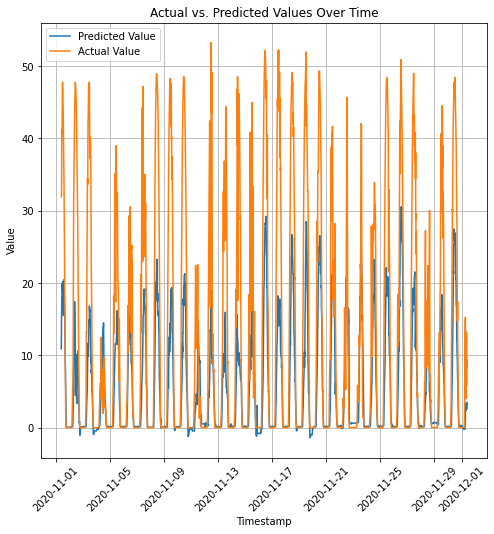

In [349]:
plt.figure(figsize=(8, 8))
plt.plot(results.index, results['Predicted'], label='Predicted Value')
plt.plot(results.index, results['Actual'], label='Actual Value')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Solar 1 

In [350]:
X_train=solar_1_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_1_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_1_train['power_output']
Y_test = solar_1_test_1['power_output']

In [351]:
X_train = X_train[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
X_test = X_test[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]

In [352]:
X_train = (X_train-X_train.mean())/X_train.std()
X_test = (X_test-X_test.mean())/X_test.std()

In [353]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.03,
    max_depth=3,
    random_state=42)

regressor.fit(X_train, Y_train)
predictions1 = regressor.predict(X_test)

MSE = mean_squared_error(Y_test, predictions1)
print("MSE:", MSE)

total = np.sum((Y_test - np.mean(Y_test))**2)
residual = np.sum((Y_test - predictions1)**2)
r_2 = 1-(residual/total)
print("R^2:", r_2)

MSE: 3.708355213268331
R^2: 0.7964838598722848


In [354]:
results1 = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions1})
results1

,Actual,Predicted
timestamp,,
2020-11-01 10:00:00,7.95,5.962600
2020-11-01 10:15:00,8.51,6.409611
2020-11-01 10:30:00,9.07,6.783735
2020-11-01 10:45:00,9.38,7.186045
2020-11-01 11:00:00,9.68,7.319266
...,...,...
2020-12-01 08:45:00,2.32,1.864475
2020-12-01 09:00:00,2.21,1.631830
2020-12-01 09:15:00,2.00,1.631830


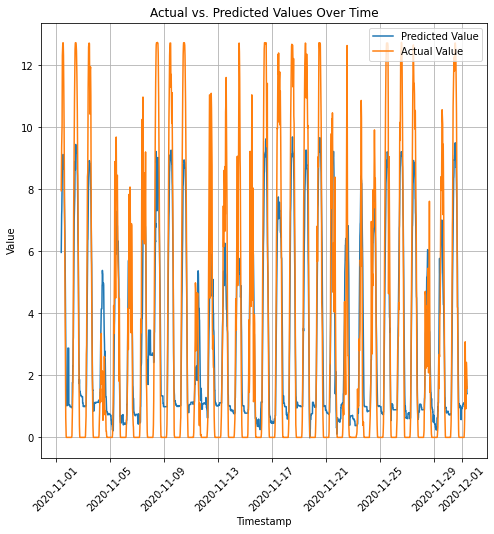

In [355]:
plt.figure(figsize=(8, 8))
plt.plot(results1.index, results1['Predicted'], label='Predicted Value')
plt.plot(results1.index, results1['Actual'], label='Actual Value')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Solar 2

In [356]:
X_train=solar_2_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_2_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_2_train['power_output']
Y_test = solar_2_test_1['power_output']

In [357]:
X_train = X_train[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
X_test = X_test[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]

In [358]:
X_train = (X_train-X_train.mean())/X_train.std()
X_test = (X_test-X_test.mean())/X_test.std()

In [359]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.03,
    max_depth=3,
    random_state=42)

regressor.fit(X_train, Y_train)
predictions2 = regressor.predict(X_test)

MSE = mean_squared_error(Y_test, predictions2)
print("MSE:", MSE)

total = np.sum((Y_test - np.mean(Y_test))**2)
residual = np.sum((Y_test - predictions2)**2)
r_2 = 1-(residual/total)
print("R^2:", r_2)

MSE: 4.066574513165221
R^2: 0.7758243929811606


In [360]:
results2 = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions2})
results2

,Actual,Predicted
timestamp,,
2020-11-01 10:00:00,8.26,5.225888
2020-11-01 10:15:00,8.11,5.583841
2020-11-01 10:30:00,7.95,5.796582
2020-11-01 10:45:00,9.12,6.060997
2020-11-01 11:00:00,10.29,6.192039
...,...,...
2020-12-01 08:45:00,2.21,1.634836
2020-12-01 09:00:00,2.10,1.573061
2020-12-01 09:15:00,1.90,1.518976


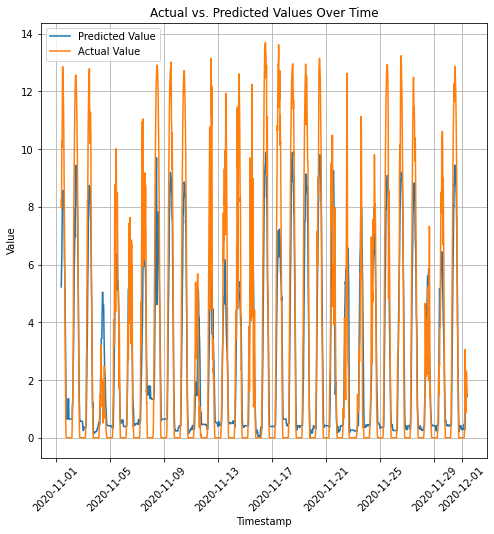

In [361]:
plt.figure(figsize=(8, 8))
plt.plot(results2.index, results2['Predicted'], label='Predicted Value')
plt.plot(results2.index, results2['Actual'], label='Actual Value')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Solar 3

In [362]:
X_train=solar_3_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_3_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_3_train['power_output']
Y_test = solar_3_test_1['power_output']

In [363]:
X_train = X_train[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
X_test = X_test[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]

In [364]:
X_train = (X_train-X_train.mean())/X_train.std()
X_test = (X_test-X_test.mean())/X_test.std()

In [365]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.03,
    max_depth=3,
    random_state=42)

regressor.fit(X_train, Y_train)
predictions3 = regressor.predict(X_test)

MSE = mean_squared_error(Y_test, predictions3)
print("MSE:", MSE)

total = np.sum((Y_test - np.mean(Y_test))**2)
residual = np.sum((Y_test - predictions3)**2)
r_2 = 1-(residual/total)
print("R^2:", r_2)

MSE: 4.783940496513802
R^2: 0.671066551640739


In [366]:
results3 = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions3})
results3

,Actual,Predicted
timestamp,,
2020-11-01 10:00:00,7.69,4.649574
2020-11-01 10:15:00,7.52,4.870956
2020-11-01 10:30:00,7.35,4.864888
2020-11-01 10:45:00,8.15,4.903442
2020-11-01 11:00:00,8.96,4.994380
...,...,...
2020-12-01 08:45:00,3.11,1.367239
2020-12-01 09:00:00,1.97,1.367239
2020-12-01 09:15:00,2.24,1.280930


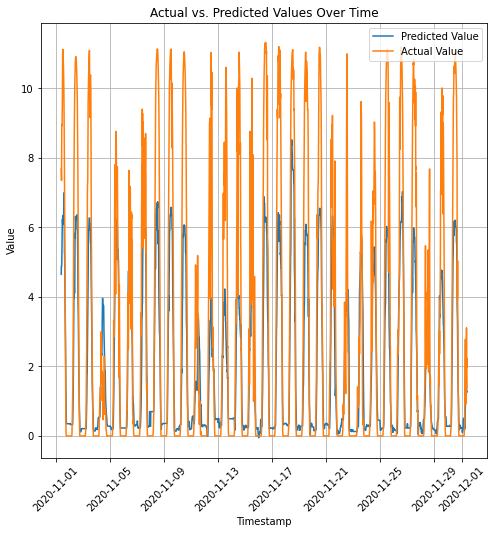

In [367]:
plt.figure(figsize=(8, 8))
plt.plot(results3.index, results3['Predicted'], label='Predicted Value')
plt.plot(results3.index, results3['Actual'], label='Actual Value')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Solar 4

In [368]:
X_train=solar_4_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_4_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_4_train['power_output']
Y_test = solar_4_test_1['power_output']

In [369]:
X_train = X_train[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
X_test = X_test[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]

In [370]:
X_train = (X_train-X_train.mean())/X_train.std()
X_test = (X_test-X_test.mean())/X_test.std()

In [371]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.03,
    max_depth=3,
    random_state=42)

regressor.fit(X_train, Y_train)
predictions4 = regressor.predict(X_test)

MSE = mean_squared_error(Y_test, predictions4)
print("MSE:", MSE)

total = np.sum((Y_test - np.mean(Y_test))**2)
residual = np.sum((Y_test - predictions4)**2)
r_2 = 1-(residual/total)
print("R^2:", r_2)

MSE: 1.3942215669555638
R^2: 0.7815487600263887


In [372]:
results4 = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions4})
results4

,Actual,Predicted
timestamp,,
2020-11-01 10:00:00,5.13,3.242763
2020-11-01 10:15:00,5.01,3.526673
2020-11-01 10:30:00,4.89,3.621590
2020-11-01 10:45:00,5.59,3.822625
2020-11-01 11:00:00,6.29,3.946779
...,...,...
2020-12-01 08:45:00,1.31,1.041545
2020-12-01 09:00:00,1.25,1.025460
2020-12-01 09:15:00,1.13,0.961901


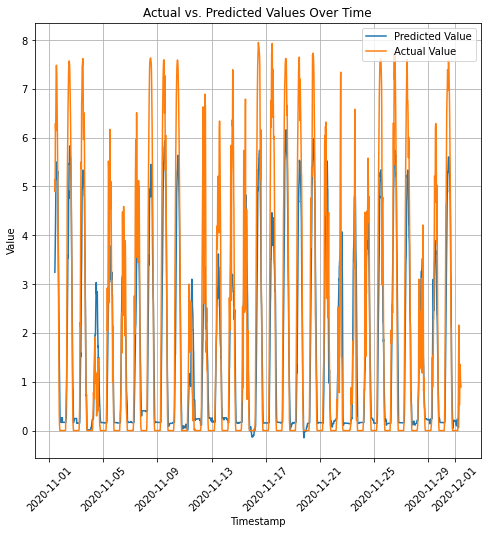

In [373]:
plt.figure(figsize=(8, 8))
plt.plot(results4.index, results4['Predicted'], label='Predicted Value')
plt.plot(results4.index, results4['Actual'], label='Actual Value')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Solar 5

In [374]:
X_train=solar_5_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_5_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_5_train['power_output']
Y_test = solar_5_test_1['power_output']

In [375]:
X_train = X_train[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]
X_test = X_test[['surface_thermal_radiation (W/m^2)','surface_solar_radiation (W/m^2)','mean_sea_level_pressure (Pa)','dewpoint_temperature (degC)','temperature (degC)']]

In [376]:
X_train = (X_train-X_train.mean())/X_train.std()
X_test = (X_test-X_test.mean())/X_test.std()

In [377]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.03,
    max_depth=3,
    random_state=42)

regressor.fit(X_train, Y_train)
predictions5 = regressor.predict(X_test)

MSE = mean_squared_error(Y_test, predictions5)
print("MSE:", MSE)

total = np.sum((Y_test - np.mean(Y_test))**2)
residual = np.sum((Y_test - predictions5)**2)
r_2 = 1-(residual/total)
print("R^2:", r_2)

MSE: 37.905336871058005
R^2: 0.7708742206740324


In [378]:
results5 = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions5})
results5

,Actual,Predicted
timestamp,,
2020-11-01 10:00:00,23.01,16.356388
2020-11-01 10:15:00,23.73,17.546608
2020-11-01 10:30:00,24.45,18.342157
2020-11-01 10:45:00,28.05,20.107664
2020-11-01 11:00:00,31.63,20.665264
...,...,...
2020-12-01 08:45:00,9.86,4.687669
2020-12-01 09:00:00,6.22,4.687669
2020-12-01 09:15:00,7.14,4.163991


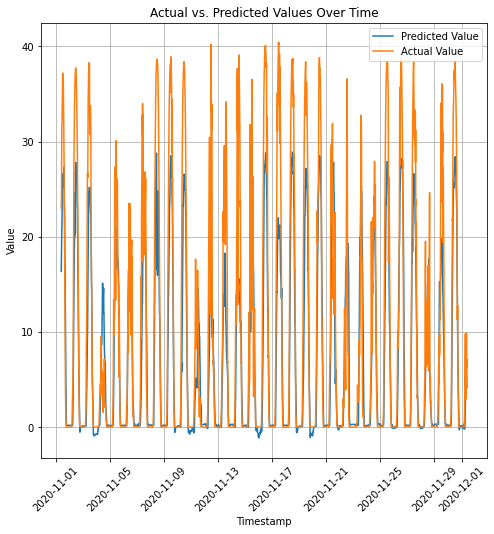

In [379]:
plt.figure(figsize=(8, 8))
plt.plot(results5.index, results5['Predicted'], label='Predicted Value')
plt.plot(results5.index, results5['Actual'], label='Actual Value')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()